ANÁLISIS CON TRADUCCIÓN AL INGLÉS Y ANALIZADO CON VADER

Primeras filas de la muestra (df_sample):
                                                text  \
0  bellísima. la vista de la ciudad, de día y noc...   
1  imperdible! gran lugar. es un clásico de de mo...   
2  excelente comida, entretenimiento y ambiente m...   
3  una maravilla única en colombia. uno de los me...   
4  esperaba más. el hotel está lindo, bien ubicad...   

                                     translated_text  label  
0  beautiful. The view of the city, day and night...      5  
1  safety pin! Great place. It is a Monterrey cla...      4  
2  Excellent food, entertainment and wonderful at...      4  
3  A unique wonder in Colombia. One of the best g...      5  
4  I expected more. The hotel is nice, well locat...      2  
Texto traducido: beautiful. The view of the city, day and night, is... | Puntaje: 0.9517
Texto traducido: safety pin! Great place. It is a Monterrey classic... | Puntaje: 0.9754
Texto traducido: Excellent food, entertainment and wonderful atmosp... 

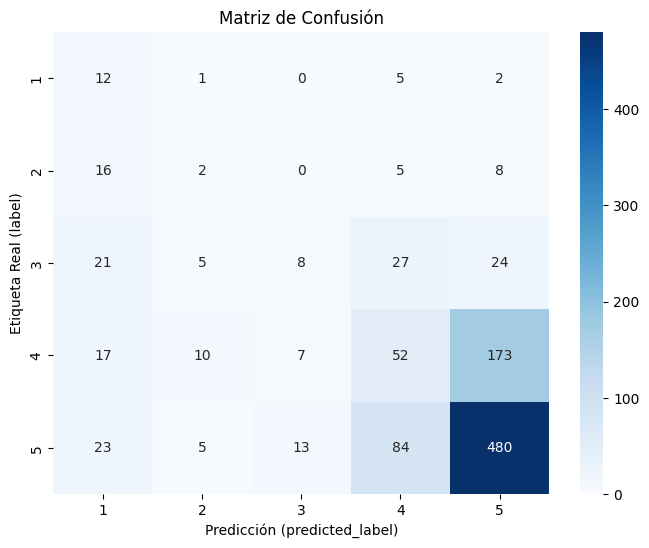


Precisión del modelo (comparando label y predicted_label): 55.40%
F1-Score del modelo (weighted): 0.5306

F1-Score por clase:
Clase 1: 0.2202
Clase 2: 0.0741
Clase 3: 0.1416
Clase 4: 0.2407
Clase 5: 0.7430


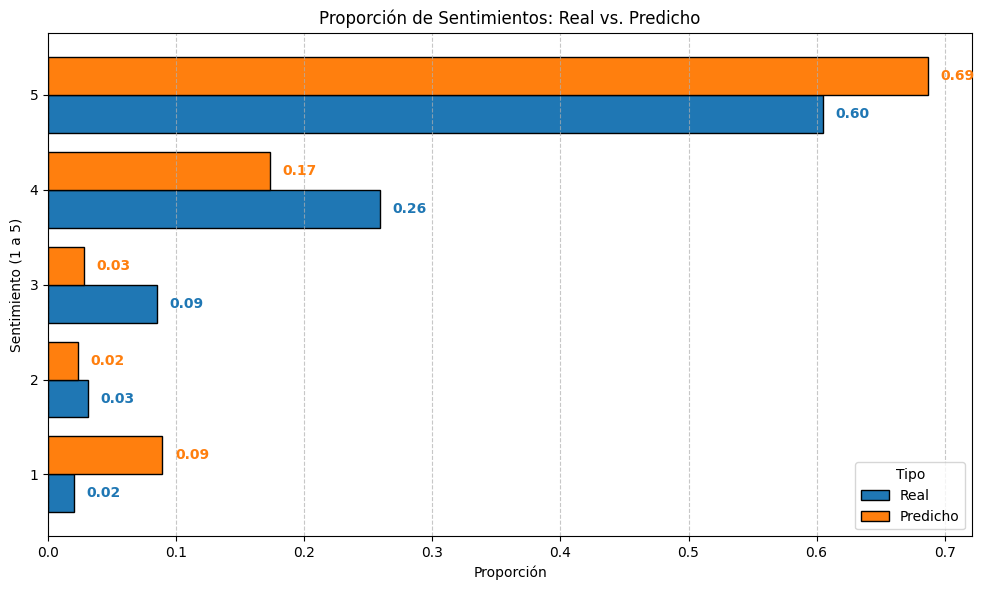

In [1]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from datasets import load_dataset
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score  # Importar f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from deep_translator import GoogleTranslator

# Cargar el dataset
full_train_dataset = load_dataset("alexcom/analisis-sentimientos-textos-turisitcos-mx-polaridad", split="train")
train_dataset = full_train_dataset.shuffle(seed=2025).select(range(int(0.3 * len(full_train_dataset))))

df = pd.DataFrame(train_dataset)
df_sample = df.head(1000).copy()

# Función para traducir texto
def traducir_texto(texto, src_lang='es', dest_lang='en'):
    try:
        traduccion = GoogleTranslator(source=src_lang, target=dest_lang).translate(texto)
        return traduccion
    except Exception as e:
        print(f"Error al traducir: {e}")
        return texto

# Aplicar la traducción
df_sample['translated_text'] = df_sample['text'].apply(traducir_texto)

print("Primeras filas de la muestra (df_sample):")
print(df_sample[['text', 'translated_text', 'label']].head())

# Inicializar VADER
analyzer = SentimentIntensityAnalyzer()

# Función para analizar sentimiento con umbrales ajustados y guardar polaridad
def vader_to_scale(translated_text):
    score = analyzer.polarity_scores(translated_text)['compound']
    print(f"Texto traducido: {translated_text[:50]}... | Puntaje: {score}")
    if score >= 0.8:  # Positivo fuerte (5)
        return 5
    elif score >= 0.4:  # Positivo moderado (4)
        return 4
    elif score > 0.2:  # Neutral (3)
        return 3
    elif score > 0.04:  # Negativo moderado (2)
        return 2
    else:  # Negativo fuerte (1)
        return 1

# Aplicar VADER y guardar polaridad en una nueva columna
df_sample['polarity'] = df_sample['translated_text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
df_sample['predicted_label'] = df_sample['translated_text'].apply(vader_to_scale)

# Mostrar distribución
print("\nDistribución de etiquetas reales (label):")
print(df_sample['label'].value_counts())
print("\nDistribución de etiquetas predichas (predicted_label):")
print(df_sample['predicted_label'].value_counts())

# Mostrar resultados
print("\nMuestra de resultados:")
print(df_sample[['text', 'translated_text', 'label', 'predicted_label', 'polarity']].head(10))

# Matriz de confusión
conf_matrix = confusion_matrix(df_sample['label'], df_sample['predicted_label'])
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
plt.xlabel('Predicción (predicted_label)')
plt.ylabel('Etiqueta Real (label)')
plt.title('Matriz de Confusión')
plt.show()

# Calcular y mostrar precisión
accuracy = accuracy_score(df_sample['label'], df_sample['predicted_label'])
print(f"\nPrecisión del modelo (comparando label y predicted_label): {accuracy * 100:.2f}%")

# Calcular F1-score (promedio weighted)
f1_weighted = f1_score(df_sample['label'], df_sample['predicted_label'], average='weighted')
print(f"F1-Score del modelo (weighted): {f1_weighted:.4f}")

# Calcular F1-score por clase
f1_per_class = f1_score(df_sample['label'], df_sample['predicted_label'], average=None, labels=[1, 2, 3, 4, 5])
print("\nF1-Score por clase:")
for label, score in zip([1, 2, 3, 4, 5], f1_per_class):
    print(f"Clase {label}: {score:.4f}")

# Calcular proporciones para la gráfica de proporciones
real_counts = df_sample['label'].value_counts(normalize=True).sort_index()
pred_counts = df_sample['predicted_label'].value_counts(normalize=True).sort_index()

proportions = pd.DataFrame({
    'Real': real_counts,
    'Predicho': pred_counts
}).fillna(0)

# Gráfica de barras horizontales con etiquetas afuera
fig, ax = plt.subplots(figsize=(10, 6))
proportions.plot(kind='barh', width=0.8, color=['#1f77b4', '#ff7f0e'], edgecolor='black', ax=ax)
plt.xlabel('Proporción')
plt.ylabel('Sentimiento (1 a 5)')
plt.title('Proporción de Sentimientos: Real vs. Predicho')
plt.legend(title='Tipo')
plt.grid(axis='x', linestyle='--', alpha=0.7)

for i, (real_val, pred_val) in enumerate(zip(proportions['Real'], proportions['Predicho'])):
    ax.text(real_val, i - 0.2, f'{real_val:.2f}', ha='left', va='center', fontweight='bold', color='#1f77b4', 
            position=(real_val + 0.01, i - 0.2))
    ax.text(pred_val, i + 0.2, f'{pred_val:.2f}', ha='left', va='center', fontweight='bold', color='#ff7f0e', 
            position=(pred_val + 0.01, i + 0.2))

plt.tight_layout()
plt.show()

In [ ]:
df_sample.head(10)

,text,label,translated_text,polarity,predicted_label
0,"bellísima. la vista de la ciudad, de día y noc...",5,"beautiful. The view of the city, day and night...",0.9517,5
1,imperdible! gran lugar. es un clásico de de mo...,4,safety pin! Great place. It is a Monterrey cla...,0.9754,5
2,"excelente comida, entretenimiento y ambiente m...",4,"Excellent food, entertainment and wonderful at...",0.9168,5
3,una maravilla única en colombia. uno de los me...,5,A unique wonder in Colombia. One of the best g...,0.9423,5
4,"esperaba más. el hotel está lindo, bien ubicad...",2,"I expected more. The hotel is nice, well locat...",0.9794,5
5,medelín desde el aire. económico y agradable t...,5,Medelin from the air. Economic and pleasant to...,0.5106,4
6,hermosa plaza. bien vale la pena conocer la pl...,5,Beautiful Plaza. It is well worth knowing the ...,0.7345,4
7,en el corazon de esta florklorica y magica ciu...,4,In the heart of this Florklorica and Magica Ci...,0.8191,5
8,hermoso paseo nocturno. no perderse el carruaj...,4,Beautiful night walk. Do not miss the carriage...,0.9251,5
9,vacaciones en puebla. pasamos la primer semana...,5,Vacation in Puebla. We spent the first week of...,0.9286,5


ANÁLISIS CON TRADUCCIÓN Y BERT

Primeras filas de la muestra (df_sample):
                                                text  \
0  bellísima. la vista de la ciudad, de día y noc...   
1  imperdible! gran lugar. es un clásico de de mo...   
2  excelente comida, entretenimiento y ambiente m...   
3  una maravilla única en colombia. uno de los me...   
4  esperaba más. el hotel está lindo, bien ubicad...   

                                     translated_text  label  
0  beautiful. The view of the city, day and night...      5  
1  safety pin! Great place. It is a Monterrey cla...      4  
2  Excellent food, entertainment and wonderful at...      4  
3  A unique wonder in Colombia. One of the best g...      5  
4  I expected more. The hotel is nice, well locat...      2  


Device set to use cpu


Texto traducido: beautiful. The view of the city, day and night, is... | Etiqueta: POSITIVE | Confianza: 0.9999
Texto traducido: safety pin! Great place. It is a Monterrey classic... | Etiqueta: POSITIVE | Confianza: 0.9999
Texto traducido: Excellent food, entertainment and wonderful atmosp... | Etiqueta: POSITIVE | Confianza: 0.9998
Texto traducido: A unique wonder in Colombia. One of the best gold ... | Etiqueta: POSITIVE | Confianza: 0.9998
Texto traducido: I expected more. The hotel is nice, well located, ... | Etiqueta: NEGATIVE | Confianza: 0.9666
Texto traducido: Medelin from the air. Economic and pleasant tour w... | Etiqueta: POSITIVE | Confianza: 0.9998
Texto traducido: Beautiful Plaza. It is well worth knowing the Plaz... | Etiqueta: POSITIVE | Confianza: 0.9997
Texto traducido: In the heart of this Florklorica and Magica City. ... | Etiqueta: POSITIVE | Confianza: 0.9848
Texto traducido: Beautiful night walk. Do not miss the carriage. Be... | Etiqueta: POSITIVE | Confianza:

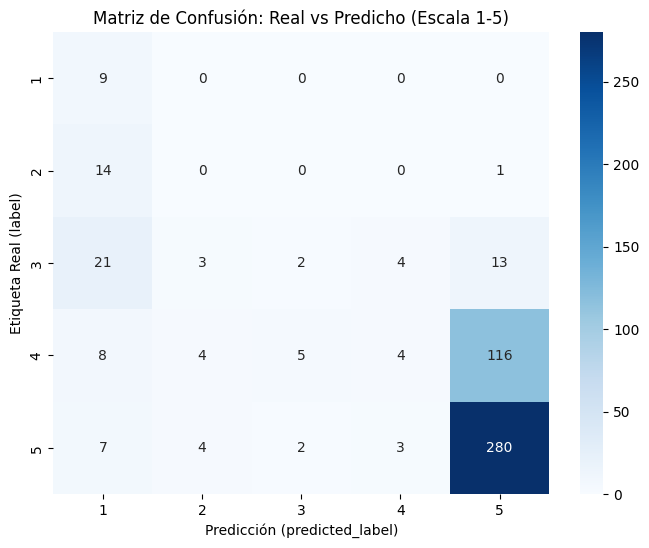


Precisión del modelo: 59.00%
F1-Score del modelo (weighted): 0.4958

F1-Score por clase:
Clase 1: 0.2647
Clase 2: 0.0000
Clase 3: 0.0769
Clase 4: 0.0541
Clase 5: 0.7932


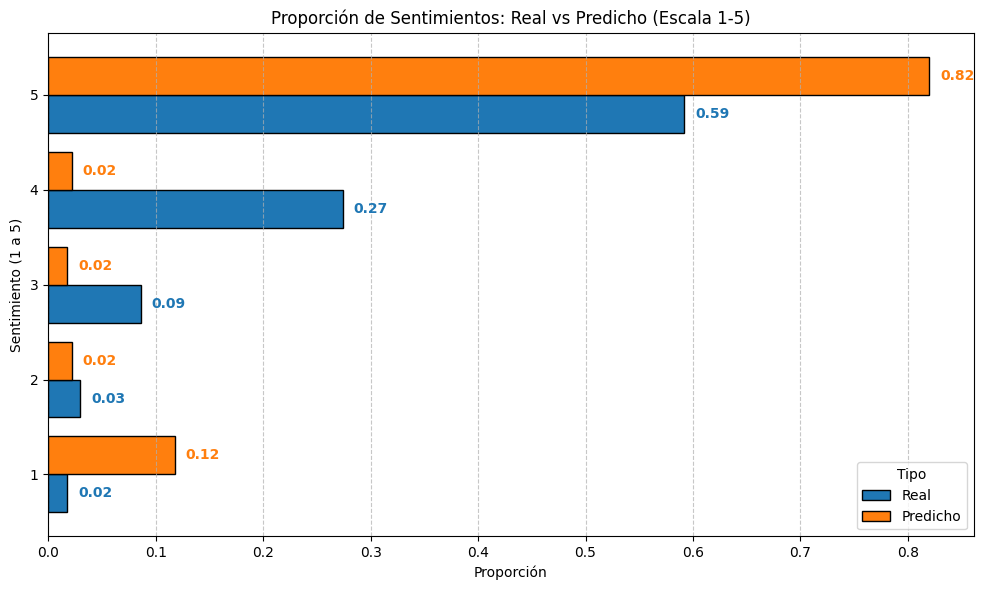

In [12]:
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from deep_translator import GoogleTranslator
import torch

# Cargar el dataset
full_train_dataset = load_dataset("alexcom/analisis-sentimientos-textos-turisitcos-mx-polaridad", split="train")
train_dataset = full_train_dataset.shuffle(seed=2025).select(range(int(0.3 * len(full_train_dataset))))

df = pd.DataFrame(train_dataset)
df_sample = df.head(500).copy()

# Función para traducir texto
def traducir_texto(texto, src_lang='es', dest_lang='en'):
    try:
        traduccion = GoogleTranslator(source=src_lang, target=dest_lang).translate(texto)
        return traduccion
    except Exception as e:
        print(f"Error al traducir: {e}")
        return texto

# Aplicar la traducción
df_sample['translated_text'] = df_sample['text'].apply(traducir_texto)

print("Primeras filas de la muestra (df_sample):")
print(df_sample[['text', 'translated_text', 'label']].head())

# Cargar el modelo BERT preentrenado y el tokenizador
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Crear pipeline de clasificación
classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)

# Función para mapear la salida de BERT a la escala 1-5
def bert_to_scale(text):
    result = classifier(text, truncation=True, max_length=512)[0]
    label = result['label']
    score = result['score']
    print(f"Texto traducido: {text[:50]}... | Etiqueta: {label} | Confianza: {score:.4f}")
    
    # Mapeo de salida binaria (POSITIVE/NEGATIVE) a escala 1-5 basado en confianza
    if label == 'POSITIVE':
        if score >= 0.95:
            return 5  # Positivo fuerte
        elif score >= 0.75:
            return 4  # Positivo moderado
        else:
            return 3  # Neutral
    else:  # NEGATIVE
        if score >= 0.95:
            return 1  # Negativo fuerte
        elif score >= 0.75:
            return 2  # Negativo moderado
        else:
            return 3  # Neutral

# Aplicar BERT y obtener predicciones
df_sample['predicted_label'] = df_sample['translated_text'].apply(bert_to_scale)

# Calcular polaridad (opcional, solo para visualización)
df_sample['polarity'] = df_sample['translated_text'].apply(
    lambda x: classifier(x, truncation=True, max_length=512)[0]['score'] * 
    (1 if classifier(x, truncation=True, max_length=512)[0]['label'] == 'POSITIVE' else -1)
)

# Asegurarse de que las etiquetas sean enteros para la comparación
df_sample['label'] = df_sample['label'].astype(int)
df_sample['predicted_label'] = df_sample['predicted_label'].astype(int)

# Mostrar distribución
print("\nDistribución de etiquetas reales (label):")
print(df_sample['label'].value_counts().sort_index())
print("\nDistribución de etiquetas predichas (predicted_label):")
print(df_sample['predicted_label'].value_counts().sort_index())

# Mostrar resultados
print("\nMuestra de resultados:")
print(df_sample[['text', 'translated_text', 'label', 'predicted_label', 'polarity']].head(10))

# Matriz de confusión
conf_matrix = confusion_matrix(df_sample['label'], df_sample['predicted_label'], labels=[1, 2, 3, 4, 5])
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
plt.xlabel('Predicción (predicted_label)')
plt.ylabel('Etiqueta Real (label)')
plt.title('Matriz de Confusión: Real vs Predicho (Escala 1-5)')
plt.show()

# Calcular y mostrar precisión
accuracy = accuracy_score(df_sample['label'], df_sample['predicted_label'])
print(f"\nPrecisión del modelo: {accuracy * 100:.2f}%")

# Calcular F1-score (promedio weighted)
f1_weighted = f1_score(df_sample['label'], df_sample['predicted_label'], average='weighted')
print(f"F1-Score del modelo (weighted): {f1_weighted:.4f}")

# Calcular F1-score por clase
f1_per_class = f1_score(df_sample['label'], df_sample['predicted_label'], average=None, labels=[1, 2, 3, 4, 5])
print("\nF1-Score por clase:")
for label, score in zip([1, 2, 3, 4, 5], f1_per_class):
    print(f"Clase {label}: {score:.4f}")

# Calcular proporciones para la gráfica
real_counts = df_sample['label'].value_counts(normalize=True).sort_index()
pred_counts = df_sample['predicted_label'].value_counts(normalize=True).sort_index()

proportions = pd.DataFrame({
    'Real': real_counts,
    'Predicho': pred_counts
}).reindex([1, 2, 3, 4, 5], fill_value=0)  # Asegura todas las clases de 1 a 5

# Gráfica de barras horizontales
fig, ax = plt.subplots(figsize=(10, 6))
proportions.plot(kind='barh', width=0.8, color=['#1f77b4', '#ff7f0e'], edgecolor='black', ax=ax)
plt.xlabel('Proporción')
plt.ylabel('Sentimiento (1 a 5)')
plt.title('Proporción de Sentimientos: Real vs Predicho (Escala 1-5)')
plt.legend(title='Tipo')
plt.grid(axis='x', linestyle='--', alpha=0.7)

for i, (real_val, pred_val) in enumerate(zip(proportions['Real'], proportions['Predicho'])):
    ax.text(real_val + 0.01, i - 0.2, f'{real_val:.2f}', ha='left', va='center', fontweight='bold', color='#1f77b4')
    ax.text(pred_val + 0.01, i + 0.2, f'{pred_val:.2f}', ha='left', va='center', fontweight='bold', color='#ff7f0e')

plt.tight_layout()
plt.show()

ANÁLISIS CON BERT EN ESPAÑOL

Primeras filas de la muestra (df_sample):
                                                text  label
0  bellísima. la vista de la ciudad, de día y noc...      5
1  imperdible! gran lugar. es un clásico de de mo...      4
2  excelente comida, entretenimiento y ambiente m...      4
3  una maravilla única en colombia. uno de los me...      5
4  esperaba más. el hotel está lindo, bien ubicad...      2


Device set to use cpu


Texto: bellísima. la vista de la ciudad, de día y noche, ... | Etiqueta: 5 stars | Confianza: 0.9165
Texto: imperdible! gran lugar. es un clásico de de monter... | Etiqueta: 5 stars | Confianza: 0.8911
Texto: excelente comida, entretenimiento y ambiente marav... | Etiqueta: 5 stars | Confianza: 0.7085
Texto: una maravilla única en colombia. uno de los mejore... | Etiqueta: 5 stars | Confianza: 0.9513
Texto: esperaba más. el hotel está lindo, bien ubicado, l... | Etiqueta: 2 stars | Confianza: 0.4724
Texto: medelín desde el aire. económico y agradable tour ... | Etiqueta: 4 stars | Confianza: 0.4889
Texto: hermosa plaza. bien vale la pena conocer la plaza ... | Etiqueta: 4 stars | Confianza: 0.4670
Texto: en el corazon de esta florklorica y magica ciudad.... | Etiqueta: 5 stars | Confianza: 0.4620
Texto: hermoso paseo nocturno. no perderse el carruaje. h... | Etiqueta: 5 stars | Confianza: 0.7414
Texto: vacaciones en puebla. pasamos la primer semana de ... | Etiqueta: 5 stars | Confianz

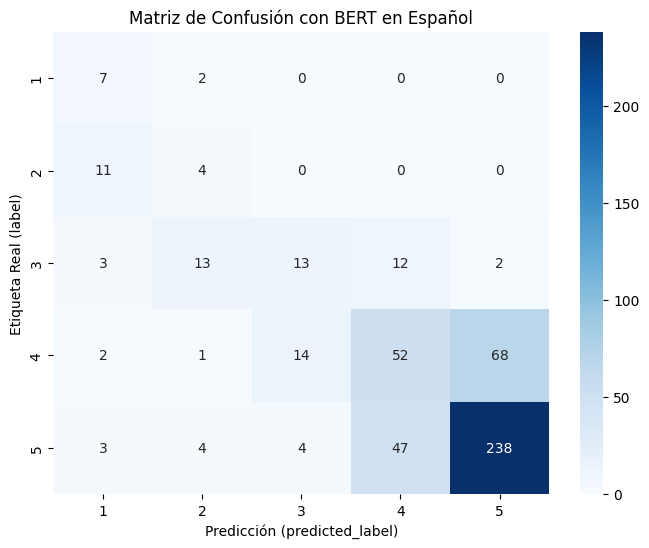


Precisión del modelo (comparando label y predicted_label): 62.80%
F1-Score del modelo (weighted): 0.6250

F1-Score por clase:
Clase 1: 0.4000
Clase 2: 0.2051
Clase 3: 0.3514
Clase 4: 0.4194
Clase 5: 0.7881


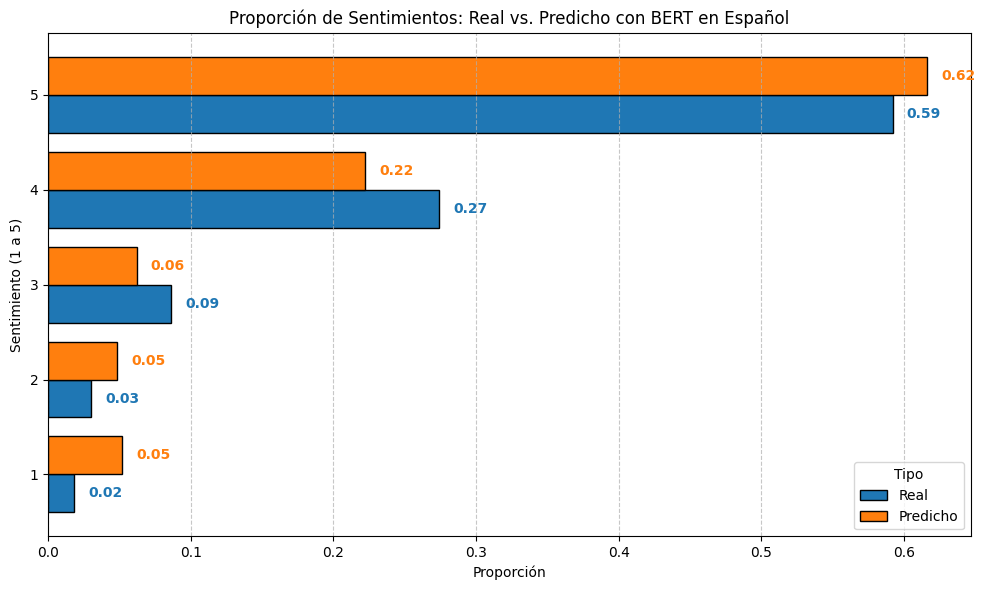

In [ ]:
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import torch

# Cargar el dataset
full_train_dataset = load_dataset("alexcom/analisis-sentimientos-textos-turisitcos-mx-polaridad", split="train")
train_dataset = full_train_dataset.shuffle(seed=2025).select(range(int(0.3 * len(full_train_dataset))))

df = pd.DataFrame(train_dataset)
df_sample = df.head(500).copy()

print("Primeras filas de la muestra (df_sample):")
print(df_sample[['text', 'label']].head())

# Cargar el modelo BERT preentrenado en español y el tokenizador
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Crear pipeline de clasificación
classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)

# Función para obtener la predicción del modelo y mapear a la escala 1-5
def bert_to_scale(text):
    result = classifier(text, truncation=True, max_length=512)[0]
    label = result['label']
    score = result['score']
    print(f"Texto: {text[:50]}... | Etiqueta: {label} | Confianza: {score:.4f}")
    
    # Mapear las etiquetas del modelo (1 star a 5 stars) a valores numéricos
    mapping = {
        '1 star': 1,
        '2 stars': 2,
        '3 stars': 3,
        '4 stars': 4,
        '5 stars': 5
    }
    return mapping[label]

# Aplicar BERT y obtener predicciones
df_sample['predicted_label'] = df_sample['text'].apply(bert_to_scale)
df_sample['polarity'] = df_sample['text'].apply(
    lambda x: classifier(x, truncation=True, max_length=512)[0]['score'] * 
    ((int(classifier(x, truncation=True, max_length=512)[0]['label'].split()[0]) - 3) / 2)  # Normaliza a [-1, 1]
)

# Mostrar distribución
print("\nDistribución de etiquetas reales (label):")
print(df_sample['label'].value_counts())
print("\nDistribución de etiquetas predichas (predicted_label):")
print(df_sample['predicted_label'].value_counts())

# Mostrar resultados
print("\nMuestra de resultados:")
print(df_sample[['text', 'label', 'predicted_label', 'polarity']].head(10))

# Matriz de confusión
conf_matrix = confusion_matrix(df_sample['label'], df_sample['predicted_label'])
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
plt.xlabel('Predicción (predicted_label)')
plt.ylabel('Etiqueta Real (label)')
plt.title('Matriz de Confusión con BERT en Español')
plt.show()

# Calcular y mostrar precisión
accuracy = accuracy_score(df_sample['label'], df_sample['predicted_label'])
print(f"\nPrecisión del modelo (comparando label y predicted_label): {accuracy * 100:.2f}%")

# Calcular F1-score (promedio weighted)
f1_weighted = f1_score(df_sample['label'], df_sample['predicted_label'], average='weighted')
print(f"F1-Score del modelo (weighted): {f1_weighted:.4f}")

# Calcular F1-score por clase
f1_per_class = f1_score(df_sample['label'], df_sample['predicted_label'], average=None, labels=[1, 2, 3, 4, 5])
print("\nF1-Score por clase:")
for label, score in zip([1, 2, 3, 4, 5], f1_per_class):
    print(f"Clase {label}: {score:.4f}")

# Calcular proporciones para la gráfica
real_counts = df_sample['label'].value_counts(normalize=True).sort_index()
pred_counts = df_sample['predicted_label'].value_counts(normalize=True).sort_index()

proportions = pd.DataFrame({
    'Real': real_counts,
    'Predicho': pred_counts
}).fillna(0)

# Gráfica de barras horizontales con etiquetas afuera
fig, ax = plt.subplots(figsize=(10, 6))
proportions.plot(kind='barh', width=0.8, color=['#1f77b4', '#ff7f0e'], edgecolor='black', ax=ax)
plt.xlabel('Proporción')
plt.ylabel('Sentimiento (1 a 5)')
plt.title('Proporción de Sentimientos: Real vs. Predicho con BERT en Español')
plt.legend(title='Tipo')
plt.grid(axis='x', linestyle='--', alpha=0.7)

for i, (real_val, pred_val) in enumerate(zip(proportions['Real'], proportions['Predicho'])):
    ax.text(real_val, i - 0.2, f'{real_val:.2f}', ha='left', va='center', fontweight='bold', color='#1f77b4', 
            position=(real_val + 0.01, i - 0.2))
    ax.text(pred_val, i + 0.2, f'{pred_val:.2f}', ha='left', va='center', fontweight='bold', color='#ff7f0e', 
            position=(pred_val + 0.01, i + 0.2))

plt.tight_layout()
plt.show()